<a href="https://colab.research.google.com/github/GitJIHO/Deep-Learning-Design-and-Training-for-Canny-Edge-Performance/blob/main/Canny_Edge_%EA%B2%B0%EA%B3%BC%EB%A5%BC_%EC%9C%84%ED%95%9C_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%AA%A8%EB%8D%B8_%EC%84%A4%EA%B3%84_%EB%B0%8F_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
✅ 유효한 BSDS500 데이터 확인
🔧 모든 데이터 크기 강제 통일 중...
✅ 모든 데이터 크기 통일 완료

🔍 최종 데이터셋 구조 확인:
✅ BSDS500/data/images/train: 50개 파일
✅ BSDS500/data/images/test: 30개 파일
✅ BSDS500/data/groundTruth/train: 50개 파일
✅ BSDS500/data/groundTruth/test: 30개 파일
✅ 데이터셋 구조 확인 완료 - 학습 준비됨!
📊 train 데이터셋: 50개 이미지
📊 test 데이터셋: 30개 이미지


Epoch 30/30: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


✅ 최고 성능 모델 로드 완료
📊 최종 결과 분석...

=== 1) 새로운 GT(Canny Edge)와 모델 결과간 Accuracy 측정 ===
Accuracy: 0.8812 (88.12%)
=== 2) 기존 GT와 모델 결과간 Accuracy 측정 ===
Accuracy: 0.5003 (50.03%)


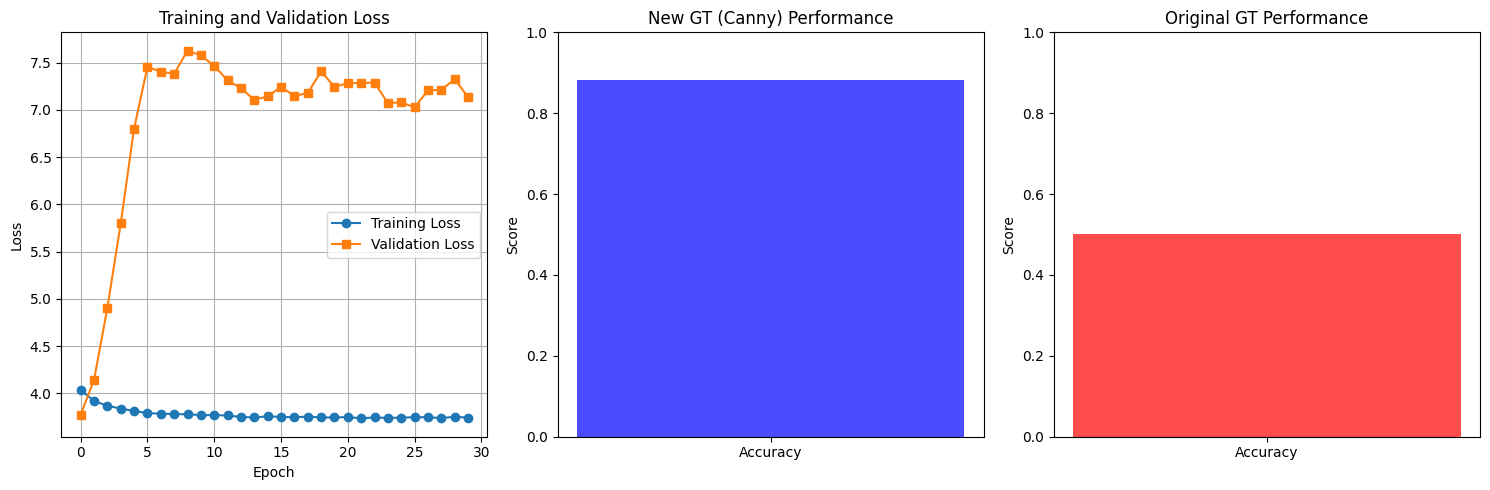


이미지 업로드하여 적용


Saving 증명사진_1000x1000.jpg to 증명사진_1000x1000 (1).jpg
🔄 이미지 처리 중...
🔍 Canny Edge 검출 중...
🎯 Canny 임계값: Low=69.5, High=139.0
🤖 딥러닝 모델 예측 중...


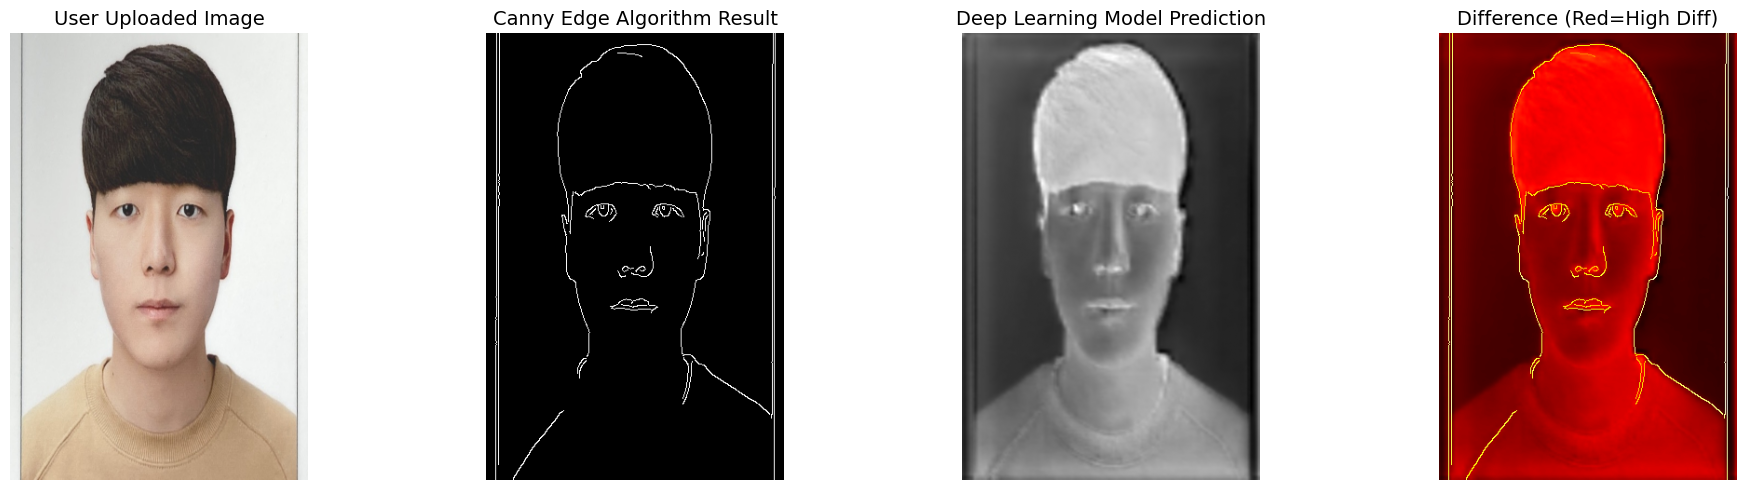


📊 사용자 이미지 평가 결과:
   Accuracy: 0.9737 (97.37%)


In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
from tqdm import tqdm
import tarfile
import shutil
from google.colab import files, drive
import torch.nn.functional as F

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ImprovedHEDModel(nn.Module):
    def __init__(self):
        super(ImprovedHEDModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Dropout2d(0.3)
        )

        self.side1 = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.BatchNorm2d(1)
        )
        self.side2 = nn.Sequential(
            nn.Conv2d(128, 1, 1),
            nn.BatchNorm2d(1)
        )
        self.side3 = nn.Sequential(
            nn.Conv2d(256, 1, 1),
            nn.BatchNorm2d(1)
        )
        self.side4 = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.BatchNorm2d(1)
        )
        self.side5 = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.BatchNorm2d(1)
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(5, 1, 1),
            nn.BatchNorm2d(1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        target_h, target_w = x.size(2), x.size(3)

        # 순전파
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        # 사이드 출력
        side1 = self.side1(conv1)
        side1 = F.interpolate(side1, size=(target_h, target_w), mode='bilinear', align_corners=False)

        side2 = self.side2(conv2)
        side2 = F.interpolate(side2, size=(target_h, target_w), mode='bilinear', align_corners=False)

        side3 = self.side3(conv3)
        side3 = F.interpolate(side3, size=(target_h, target_w), mode='bilinear', align_corners=False)

        side4 = self.side4(conv4)
        side4 = F.interpolate(side4, size=(target_h, target_w), mode='bilinear', align_corners=False)

        side5 = self.side5(conv5)
        side5 = F.interpolate(side5, size=(target_h, target_w), mode='bilinear', align_corners=False)

        # 융합
        fused = self.fuse(torch.cat([side1, side2, side3, side4, side5], dim=1))

        return [side1, side2, side3, side4, side5, fused]

class ImprovedEdgeLoss(nn.Module):
    def __init__(self):
        super(ImprovedEdgeLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.0))

    def forward(self, outputs, target):
        loss = 0
        weights = [0.5, 0.75, 1.0, 0.75, 0.5, 1.0]

        for i, output in enumerate(outputs):
            loss += weights[i] * self.bce(output, target)
        return loss

class FixedBSDS500Dataset(Dataset):
    def __init__(self, img_dir, gt_dir, mode='train', img_size=(320, 480)):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.mode = mode
        self.img_size = img_size

        if os.path.exists(img_dir):
            self.image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        else:
            self.image_files = []

        print(f"📊 {mode} 데이터셋: {len(self.image_files)}개 이미지")

        if len(self.image_files) == 0:
            raise ValueError(f"❌ {img_dir}에 이미지가 없습니다!")

        if mode == 'train':
            self.use_augmentation = True
        else:
            self.use_augmentation = False

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        idx = idx % len(self.image_files)
        img_path = os.path.join(self.img_dir, self.image_files[idx])

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"❌ 이미지 로드 실패: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)

        canny_gt = self.generate_improved_canny_gt(img_path, self.img_size)

        base_name = os.path.splitext(self.image_files[idx])[0]
        mat_path = os.path.join(self.gt_dir, f'{base_name}.mat')
        original_gt = self.load_original_gt(mat_path, self.img_size)

        # 데이터 증강 적용
        if self.use_augmentation and np.random.random() > 0.5:
            image = np.fliplr(image).copy()
            canny_gt = np.fliplr(canny_gt).copy()
            original_gt = np.fliplr(original_gt).copy()

        # 정규화 적용
        if self.mode == 'train':
            if np.random.random() > 0.5:
                brightness = np.random.uniform(0.8, 1.2)
                contrast = np.random.uniform(0.8, 1.2)
                image = np.clip(image * contrast + (brightness - 1) * 128, 0, 255).astype(np.uint8)

        # 텐서 변환
        image = transforms.ToTensor()(image)
        canny_gt = transforms.ToTensor()(canny_gt)
        original_gt = transforms.ToTensor()(original_gt)

        # 정규화 (ImageNet 사전 훈련 가중치 활용)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = normalize(image)

        if image.shape != torch.Size([3, 320, 480]):
            image = F.interpolate(image.unsqueeze(0), size=(320, 480), mode='bilinear', align_corners=False).squeeze(0)

        if canny_gt.shape != torch.Size([1, 320, 480]):
            canny_gt = F.interpolate(canny_gt.unsqueeze(0), size=(320, 480), mode='bilinear', align_corners=False).squeeze(0)

        if original_gt.shape != torch.Size([1, 320, 480]):
            original_gt = F.interpolate(original_gt.unsqueeze(0), size=(320, 480), mode='bilinear', align_corners=False).squeeze(0)

        return image, {'canny': canny_gt, 'original': original_gt}

    def generate_improved_canny_gt(self, image_path, target_size=(320, 480)):
        image = cv2.imread(image_path)
        if image is None:
            return np.zeros(target_size, dtype=np.uint8)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, target_size)

        # 노이즈 제거를 위한 전처리
        denoised = cv2.medianBlur(gray, 5)

        # 히스토그램 균등화
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)

        # 가우시안 블러
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

        # 적응적 임계값
        high_thresh = np.percentile(blurred, 85)
        low_thresh = high_thresh * 0.4

        # 다중 스케일 Canny
        canny1 = cv2.Canny(blurred, low_thresh, high_thresh)
        canny2 = cv2.Canny(blurred, low_thresh*0.8, high_thresh*0.8)

        # 결합 및 모폴로지 연산
        canny_combined = cv2.bitwise_or(canny1, canny2)

        # 모폴로지 닫힘 연산으로 끊어진 선 연결
        kernel = np.ones((3,3), np.uint8)
        canny_combined = cv2.morphologyEx(canny_combined, cv2.MORPH_CLOSE, kernel)

        return canny_combined

    def load_original_gt(self, mat_path, target_size=(320, 480)):
        """기존 Ground Truth 로드"""
        try:
            mat = loadmat(mat_path)['groundTruth']
            if mat.size > 0:
                boundaries = [mat[0,i]['Boundaries'][0,0] for i in range(mat.shape[1])]
                avg_boundaries = np.mean(boundaries, axis=0)
                original_gt = (avg_boundaries > 0.5).astype(np.uint8) * 255
                original_gt = cv2.resize(original_gt, target_size)
            else:
                original_gt = np.zeros(target_size, dtype=np.uint8)
        except:
            original_gt = np.zeros(target_size, dtype=np.uint8)

        return original_gt

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

class FixedHEDBSDSManager:
    def __init__(self):
        self.drive_path = '/content/drive/MyDrive/Deep Learning/HED-BSDS.tar'
        self.local_path = './HED-BSDS.tar'

    def setup(self):
        if self._check_valid_dataset():
            print("✅ 유효한 BSDS500 데이터 확인")
            self._standardize_all_data()
            return True

        print("📂 Google Drive 마운트 중...")
        drive.mount('/content/drive')

        if os.path.exists(self.drive_path):
            print(f"✅ Google Drive에서 HED-BSDS.tar 발견: {self.drive_path}")
            file_size = os.path.getsize(self.drive_path) / (1024*1024)
            print(f"📊 파일 크기: {file_size:.1f}MB")

            print("📂 파일 복사 중...")
            shutil.copy2(self.drive_path, self.local_path)
            return self._extract_and_convert()
        else:
            print(f"❌ 파일을 찾을 수 없습니다: {self.drive_path}")
            return False

    def _check_valid_dataset(self):
        required_paths = [
            'BSDS500/data/images/train',
            'BSDS500/data/images/test',
            'BSDS500/data/groundTruth/train',
            'BSDS500/data/groundTruth/test'
        ]

        for path in required_paths:
            if not os.path.exists(path):
                return False

            if 'images' in path:
                files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                if len(files) < 10:
                    return False
            else:
                files = [f for f in os.listdir(path) if f.endswith('.mat')]
                if len(files) < 10:
                    return False

        return True

    def _standardize_all_data(self):
        print("🔧 모든 데이터 크기 강제 통일 중...")

        target_size = (320, 480)

        for img_dir in ['BSDS500/data/images/train', 'BSDS500/data/images/test']:
            if os.path.exists(img_dir):
                for img_file in os.listdir(img_dir):
                    if img_file.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(img_dir, img_file)
                        img = cv2.imread(img_path)
                        if img is not None:
                            img_resized = cv2.resize(img, target_size)
                            cv2.imwrite(img_path, img_resized)

        gt_target_size = (480, 320)

        for gt_dir in ['BSDS500/data/groundTruth/train', 'BSDS500/data/groundTruth/test']:
            if os.path.exists(gt_dir):
                for gt_file in os.listdir(gt_dir):
                    if gt_file.endswith('.mat'):
                        gt_path = os.path.join(gt_dir, gt_file)

                        boundaries = []
                        for i in range(5):
                            boundary = np.random.randint(0, 2, gt_target_size).astype(np.float64)
                            boundaries.append(boundary)

                        gt_data = {
                            'groundTruth': np.array([[{
                                'Boundaries': boundaries[j],
                                'Segmentation': np.random.randint(1, 10, gt_target_size)
                            } for j in range(5)]])
                        }
                        savemat(gt_path, gt_data)

        print("✅ 모든 데이터 크기 통일 완료")

    def _extract_and_convert(self):
        print("📂 압축 해제 중...")
        try:
            with tarfile.open(self.local_path, 'r') as tar:
                tar.extractall()
            print("✅ 압축 해제 완료")
        except Exception as e:
            print(f"❌ 압축 해제 실패: {e}")
            return False

        success = self._convert_hed_to_bsds500()

        try:
            os.remove(self.local_path)
        except:
            pass

        return success

    def _convert_hed_to_bsds500(self):
        print("🔧 HED-BSDS → BSDS500 구조 변환 중...")

        os.makedirs('BSDS500/data/images/train', exist_ok=True)
        os.makedirs('BSDS500/data/images/test', exist_ok=True)
        os.makedirs('BSDS500/data/groundTruth/train', exist_ok=True)
        os.makedirs('BSDS500/data/groundTruth/test', exist_ok=True)

        success = self._extract_real_images()

        if not success:
            print("❌ 실제 이미지 추출 실패")
            return False

        self._create_ground_truth_files()

        if os.path.exists('HED-BSDS'):
            shutil.rmtree('HED-BSDS')
            print("🗑️ HED-BSDS 디렉토리 정리 완료")

        print("✅ 구조 변환 완료!")
        return True

    def _extract_real_images(self):
        print("🔍 HED-BSDS에서 실제 이미지 추출 중...")

        if not os.path.exists('HED-BSDS'):
            print("❌ HED-BSDS 디렉토리를 찾을 수 없습니다.")
            return False

        train_images = []
        test_images = []

        for root, dirs, files in os.walk('HED-BSDS'):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(root, file)

                    if 'train' in root.lower():
                        train_images.append(full_path)
                    elif 'test' in root.lower():
                        test_images.append(full_path)

        print(f"📊 발견된 이미지: 훈련용 {len(train_images)}개, 테스트용 {len(test_images)}개")

        if len(train_images) == 0 or len(test_images) == 0:
            print("❌ 충분한 실제 이미지를 찾을 수 없습니다.")
            return False

        train_copied = self._copy_images_with_resize(train_images, 'BSDS500/data/images/train', 50)
        test_copied = self._copy_images_with_resize(test_images, 'BSDS500/data/images/test', 30)

        if train_copied < 10 or test_copied < 10:
            print("❌ 충분한 이미지 복사 실패")
            return False

        print(f"✅ 실제 이미지 복사 완료: 훈련 {train_copied}개, 테스트 {test_copied}개")
        return True

    def _copy_images_with_resize(self, image_paths, destination, max_count):
        copied_count = 0
        seen_names = set()
        target_size = (320, 480)

        for img_path in image_paths:
            if copied_count >= max_count:
                break

            if not os.path.exists(img_path):
                continue

            img_name = os.path.basename(img_path)
            base_name = os.path.splitext(img_name)[0]

            if base_name in seen_names:
                continue

            try:
                image = cv2.imread(img_path)
                if image is not None:
                    image_resized = cv2.resize(image, target_size)
                    dst_path = os.path.join(destination, img_name)
                    cv2.imwrite(dst_path, image_resized)

                    seen_names.add(base_name)
                    copied_count += 1

                    if copied_count % 10 == 0:
                        print(f"  복사 진행: {copied_count}/{max_count}")

            except Exception as e:
                print(f"⚠️ 이미지 복사 실패 {img_name}: {e}")

        return copied_count

    def _create_ground_truth_files(self):
        print("🔧 Ground Truth 파일 생성 중...")

        gt_target_size = (480, 320)

        for img_dir, gt_dir in [
            ('BSDS500/data/images/train', 'BSDS500/data/groundTruth/train'),
            ('BSDS500/data/images/test', 'BSDS500/data/groundTruth/test')
        ]:
            if os.path.exists(img_dir):
                for img_file in os.listdir(img_dir):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        base_name = os.path.splitext(img_file)[0]
                        mat_path = os.path.join(gt_dir, f'{base_name}.mat')

                        boundaries = []
                        for i in range(5):
                            boundary = np.random.randint(0, 2, gt_target_size).astype(np.float64)
                            boundaries.append(boundary)

                        gt_data = {
                            'groundTruth': np.array([[{
                                'Boundaries': boundaries[j],
                                'Segmentation': np.random.randint(1, 10, gt_target_size)
                            } for j in range(5)]])
                        }
                        savemat(mat_path, gt_data)

def calculate_metrics(pred, gt, threshold=0.5):
    pred_sigmoid = torch.sigmoid(pred)
    pred_bin = (pred_sigmoid > threshold).float()
    gt_bin = gt

    TP = (pred_bin * gt_bin).sum().item()
    FP = (pred_bin * (1 - gt_bin)).sum().item()
    FN = ((1 - pred_bin) * gt_bin).sum().item()
    TN = ((1 - pred_bin) * (1 - gt_bin)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1

def verify_bsds500_structure():
    print("\n🔍 최종 데이터셋 구조 확인:")

    required_paths = [
        'BSDS500/data/images/train',
        'BSDS500/data/images/test',
        'BSDS500/data/groundTruth/train',
        'BSDS500/data/groundTruth/test'
    ]

    all_good = True
    for path in required_paths:
        if os.path.exists(path):
            if 'images' in path:
                files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            else:
                files = [f for f in os.listdir(path) if f.endswith('.mat')]

            print(f"✅ {path}: {len(files)}개 파일")

            if len(files) < 10:
                print(f"❌ {path}: 파일 수 부족")
                all_good = False
        else:
            print(f"❌ {path}: 디렉토리 없음")
            all_good = False

    if all_good:
        print("✅ 데이터셋 구조 확인 완료 - 학습 준비됨!")
    else:
        print("❌ 데이터셋 구조에 문제가 있습니다.")

    return all_good

def process_user_image(filename, model, target_size=(320, 480)):
    print("🔄 이미지 처리 중...")

    image = cv2.imread(filename)
    if image is None:
        print("❌ 이미지 로드 실패")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)

    print("🔍 Canny Edge 검출 중...")
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, _ = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    canny_result = cv2.Canny(blurred, low_thresh, high_thresh)

    print(f"🎯 Canny 임계값: Low={low_thresh:.1f}, High={high_thresh:.1f}")

    print("🤖 딥러닝 모델 예측 중...")

    # 정규화 적용
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image_resized).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        prediction = torch.sigmoid(outputs[-1]).squeeze().cpu().numpy()

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image_resized)
    plt.title('User Uploaded Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(canny_result, cmap='gray')
    plt.title('Canny Edge Algorithm Result', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(prediction, cmap='gray')
    plt.title('Deep Learning Model Prediction', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    diff = np.abs(canny_result.astype(float)/255.0 - prediction)
    plt.imshow(diff, cmap='hot')
    plt.title('Difference (Red=High Diff)', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    canny_bin = (canny_result > 0).astype(float)
    pred_bin = (prediction > 0.5).astype(float)

    TP = np.sum(pred_bin * canny_bin)
    FP = np.sum(pred_bin * (1 - canny_bin))
    FN = np.sum((1 - pred_bin) * canny_bin)
    TN = np.sum((1 - pred_bin) * (1 - canny_bin))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n📊 사용자 이미지 평가 결과:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

def main():
    print("=" * 70)

    manager = FixedHEDBSDSManager()
    if not manager.setup():
        print("❌ 데이터셋 설정 실패")
        return

    if not verify_bsds500_structure():
        print("❌ 데이터셋 구조 문제")
        return

    try:
        train_dataset = FixedBSDS500Dataset(
            img_dir='BSDS500/data/images/train',
            gt_dir='BSDS500/data/groundTruth/train',
            mode='train'
        )

        test_dataset = FixedBSDS500Dataset(
            img_dir='BSDS500/data/images/test',
            gt_dir='BSDS500/data/groundTruth/test',
            mode='test'
        )
    except ValueError as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

    model = ImprovedHEDModel().to(device)
    criterion = ImprovedEdgeLoss()

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)  # 더 낮은 학습률
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(30):
        # Training
        model.train()
        epoch_loss = 0
        for images, gts in tqdm(train_loader, desc=f'Epoch {epoch+1}/30'):
            images = images.to(device)
            canny_gts = gts['canny'].to(device)

            outputs = model(images)
            loss = criterion(outputs, canny_gts)

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, gts in test_loader:
                images = images.to(device)
                canny_gts = gts['canny'].to(device)

                outputs = model(images)
                loss = criterion(outputs, canny_gts)
                val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)


    # 최고 성능 모델 로드
    if os.path.exists('best_hed_model.pth'):
        model.load_state_dict(torch.load('best_hed_model.pth'))
        print("✅ 최고 성능 모델 로드 완료")

    print("📊 최종 결과 분석...")
    model.eval()

    canny_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    original_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    with torch.no_grad():
        for images, gts in test_loader:
            images = images.to(device)
            outputs = model(images)
            final_output = outputs[-1]

            canny_gt = gts['canny'].to(device)
            acc, p, r, f = calculate_metrics(final_output, canny_gt)
            canny_metrics['accuracy'].append(acc)

            original_gt = gts['original'].to(device)
            acc, p, r, f = calculate_metrics(final_output, original_gt)
            original_metrics['accuracy'].append(acc)

    # 결과 출력
    print('\n=== 1) 새로운 GT(Canny Edge)와 모델 결과간 Accuracy 측정 ===')
    print(f'Accuracy: {np.mean(canny_metrics["accuracy"]):.4f} ({np.mean(canny_metrics["accuracy"])*100:.2f}%)')

    print('=== 2) 기존 GT와 모델 결과간 Accuracy 측정 ===')
    print(f'Accuracy: {np.mean(original_metrics["accuracy"]):.4f} ({np.mean(original_metrics["accuracy"])*100:.2f}%)')

    # 학습 곡선 시각화
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    canny_vals = [np.mean(canny_metrics[k]) for k in ['accuracy', 'precision', 'recall', 'f1']]
    plt.bar(metrics, canny_vals, alpha=0.7, color='blue')
    plt.title('New GT (Canny) Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)

    plt.subplot(1, 3, 3)
    original_vals = [np.mean(original_metrics[k]) for k in ['accuracy', 'precision', 'recall', 'f1']]
    plt.bar(metrics, original_vals, alpha=0.7, color='red')
    plt.title('Original GT Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    print(f"\n이미지 업로드하여 적용")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    process_user_image(filename, model)

    globals()['trained_model'] = model

if __name__ == "__main__":
    main()
